In [1]:
# Last change: FA, Feb 22 2022

# NGC 1605 is not a binary cluster
### Analysing the putative "old binary cluster" of [Camargo (2021, ApJ)](https://ui.adsabs.harvard.edu/abs/2021arXiv210914664C/abstract) with Gaia EDR3 and several clustering techniques

In [2]:
import numpy as np
#import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter
import matplotlib.gridspec as gridspec

import astropy.table
from astropy.table import Table, Column, MaskedColumn 
from astropy.visualization import astropy_mpl_style
from scipy.stats import gaussian_kde
from astropy.stats import bayesian_blocks, histogram
import seaborn as sns
import os.path

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=True)

import hdbscan
import seaborn as sns
import sklearn.cluster

## Preparing the Gaia  EDR3 sample

Select stars in the vicinity of the cluster from the [Gaia archive](https://gea.esac.esa.int/archive/):

In [3]:
data = Table.read("./data/ngc_1605_region_gaiaedr3.fits")

Alternatively, we can use astroquery to perform the query on the fly:

# Membership analyses for NGC 1605

We test various methods to determine membership for the cluster in question and demonstrate that there is no solid evidence for this object hosting multiple populations:

## 1. DBSCAN - Castro-Ginard et al. (2022) membership list

[Castro-Ginard et al. (2022)](https://ui.adsabs.harvard.edu/abs/2021arXiv211101819C/abstract) carried out a blind search for open-cluster-like overdensities in the Gaia EDR3 data (using five dimensions: ${\tt ra, dec, pmra, pmdec, parallax}$). They find a single overdensity in the field of NGC 1605:

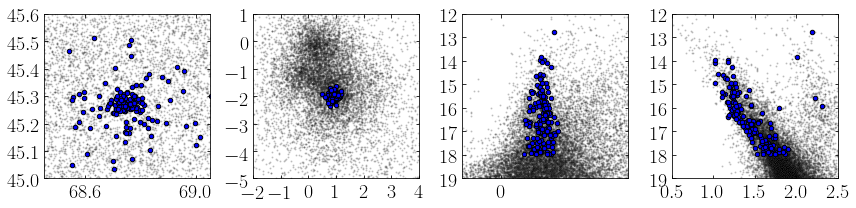

In [4]:
castroginard_2022_ngc1605 = Table.read("./data/NGC1605_dbscan.csv", format="csv")
dbscan_members            = castroginard_2022_ngc1605["source_id"]

clist = ["blue", "orange", "green", "yellow", "red"]

f = plt.figure(figsize=(12, 3))
axlist= [141, 142, 143, 144]
x_axes= ["ra", "pmra", "parallax", "bp_rp"]
y_axes= ["dec", "pmdec", "phot_g_mean_mag", "phot_g_mean_mag"]
lims  = [[68.45, 69.05, 45.0, 45.6], [-2, 4, -5, 1], [-.3, 1, 19, 12], [.5, 2.5, 19, 12] ]

for jj in [0,1,2,3]: 
    ax = f.add_subplot(plt.Subplot(f, axlist[jj]))
    plt.scatter(data[x_axes[jj]], data[y_axes[jj]], s=1, c="grey", alpha=0.2)
    for id in dbscan_members:
        plt.scatter(data[data["source_id"]==id][x_axes[jj]], 
                    data[data["source_id"]==id][y_axes[jj]], c="blue")
    if jj in [0,2]:
        ax.set_xticks(ax.get_xticks()[::2])
    plt.axis(lims[jj])
plt.tight_layout()

There is no hint for a double sequence in the CMD, only a noisy main sequence (due to differential extinction within the cluster) and a few field contaminants that are much redder.

The left plot also shows little evidence of the tidal features reported by [Camargo (2021)](https://ui.adsabs.harvard.edu/abs/2021arXiv210914664C/abstract).

## 2. pyUPMASK membership analysis

We also tested the algorithm pyUPMASK ([Pera et al. 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...650A.109P/abstract)) using the default parameters and a membership probability cut $P_{memb}>0.95$. The results are very similar (but go to fainter magnitudes):

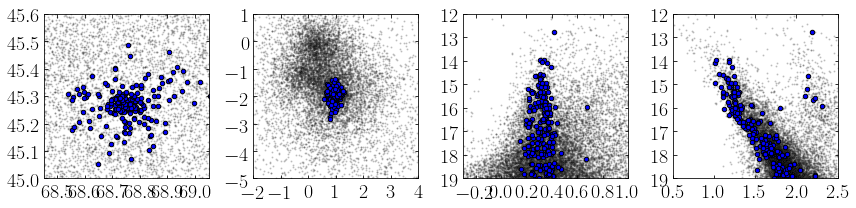

In [5]:
pyupmask_ngc1605 = Table.read("./data/ngc_1605_pyupmask_pm95.fits", format="fits")
pyupmask_members = pyupmask_ngc1605["source_id"]

clist = ["blue", "orange", "green", "yellow", "red"]

f = plt.figure(figsize=(12, 3))
axlist= [141, 142, 143, 144]
x_axes= ["ra", "pmra", "parallax", "bp_rp"]
y_axes= ["dec", "pmdec", "phot_g_mean_mag", "phot_g_mean_mag"]
lims  = [[68.45, 69.05, 45.0, 45.6], [-2, 4, -5, 1], [-.3, 1, 19, 12], [.5, 2.5, 19, 12] ]

for jj in [0,1,2,3]: 
    ax = f.add_subplot(plt.Subplot(f, axlist[jj]))
    plt.scatter(data[x_axes[jj]], data[y_axes[jj]], s=1, c="grey", alpha=0.2)
    for id in pyupmask_members:
        plt.scatter(data[data["source_id"]==id][x_axes[jj]], 
                    data[data["source_id"]==id][y_axes[jj]], c="blue")
    #if jj in [0,2]:
    #    ax.set_xticks(ax.get_xticks()[::2])
    plt.axis(lims[jj])
plt.tight_layout()

## 3. HDBSCAN Clustering


HDBSCAN ([McInnes et al. 2017](https://ui.adsabs.harvard.edu/abs/2017JOSS....2..205M/abstract)) is the hierarchical version of DBSCAN and as such has some advantages over DBSCAN. [Hunt & Reffert (2021)](https://ui.adsabs.harvard.edu/abs/2021A%26A...646A.104H/abstract) demonstrated that it can outperform other clustering algorithms for automated open cluster searches, at least in terms of completeness.

Here we demonstrate that also HDBSCAN returns the presence of two candidate clusters in the field of NGC 1605 (but the second one is at least several hundred parsecs away!):

In [6]:
# get the five-dimensional astrometric parameter space
X = np.c_[ np.array(data["ra"]), np.array(data["dec"]), np.array(data["pmra"]), 
           np.array(data["pmdec"]), np.array(data["parallax"]) ]
# rescale it:
X = ( X - np.mean(X, axis=0) ) / np.std(X, axis=0)

Now we run HDBSCAN. After [playing a bit with the main HDBSCAN parameters](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html#selecting-min-samples) (mostly ${\tt min\_cluster\_size}$ and ${\tt min\_samples}$), we see that we get reliable results and almost always find either two clusters or none at all:

In [7]:
labels     =hdbscan.HDBSCAN(min_cluster_size=60).fit_predict(X)
print("Clustering labels: ", np.unique(labels))

Clustering labels:  [-1]


In [8]:
labels     =hdbscan.HDBSCAN(min_cluster_size=10).fit_predict(X)
print("Clustering labels: ", np.unique(labels))

Clustering labels:  [-1  0  1]


In [9]:
labels     =hdbscan.HDBSCAN(min_cluster_size=30).fit_predict(X)
print("Clustering labels: ", np.unique(labels))

Clustering labels:  [-1  0  1]


So let's have look at the data & **create Fig. 1 of our Research Note**:

/home/friedel/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/home/friedel/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/friedel/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/friedel/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/friedel/anaconda3/lib/python3.7/site-p

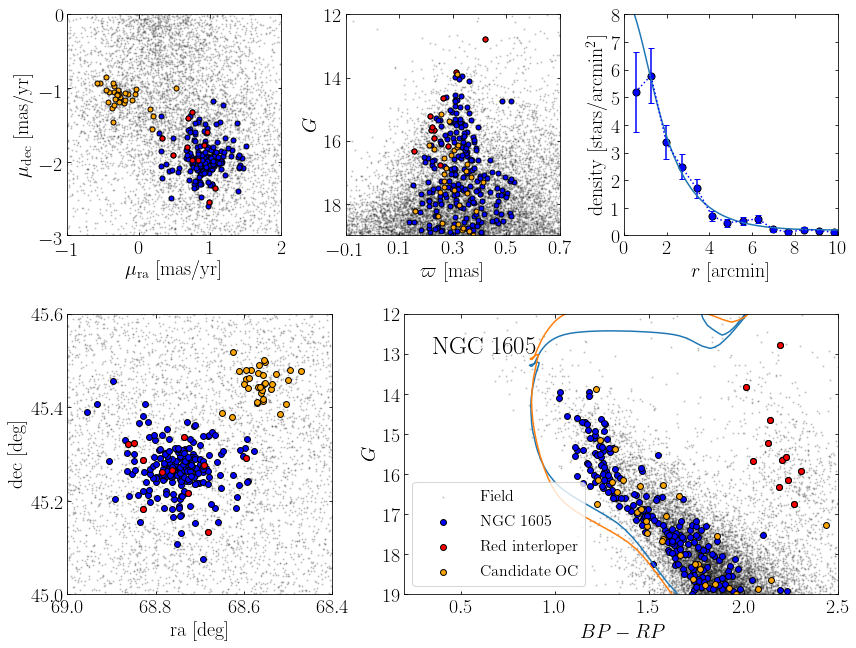

In [103]:
clist = ["blue", "orange", "green", "yellow", "red"]

f = plt.figure(figsize=(12, 9), tight_layout=True)
#plt.suptitle("HDBSCAN analysis of NGC 1605")
gs = gridspec.GridSpec(10, 3, wspace=.3)
gs1= gridspec.GridSpec(10, 10)

axlist= [gs1[5:, 0:4], gs[0:4, 0], gs[0:4, 1], gs1[5:, 4:]]#[141, 142, 143, 144]
x_axes= ["ra", "pmra", "parallax", "bp_rp"]
y_axes= ["dec", "pmdec", "phot_g_mean_mag", "phot_g_mean_mag"]
lims  = [[68.97, 68.47, 45.05, 45.55], [-1, 2, -3, 0], [-.1, .7, 19, 12], [.2, 2.5, 19, 12] ]
x_labels= ["ra [deg]", r"$\mu_{\rm ra}$ [mas/yr]", r"$\varpi$ [mas]", "$BP-RP$"]
y_labels= ["dec [deg]", r"$\mu_{\rm dec}$ [mas/yr]", "$G$", "$G$"]
sizes = [35,25,25,35]

for jj in [0,1,2,3]: 
    ax = f.add_subplot(axlist[jj])
    plt.scatter(data[x_axes[jj]], data[y_axes[jj]], s=1, c="grey", alpha=0.2, label="Field")
    #for ii in np.unique(labels)[1:]:
    plt.scatter(data[labels==0][x_axes[jj]], data[labels==0][y_axes[jj]], 
                    c=clist[0], s=sizes[jj], label="NGC 1605")
    # Highlight some of the problematic "members" of NGC 1605:
    ngc1605 = data[labels==0]
    redseq  = (ngc1605["bp_rp"] > 1.8) & (ngc1605["phot_g_mean_mag"] < 17)
    #badruwe = (ngc1605["ruwe"] > 1.4) 
    plt.scatter(ngc1605[x_axes[jj]][redseq], ngc1605[y_axes[jj]][redseq], 
                c="r", s=sizes[jj], label="Red interloper")
    plt.scatter(data[labels==1][x_axes[jj]], data[labels==1][y_axes[jj]], 
                    c=clist[1], s=sizes[jj], label="Candidate OC")
    plt.axis(lims[jj])
    #plt.scatter(ngc1605[x_axes[jj]][badruwe], ngc1605[y_axes[jj]][badruwe], 
    #            c="w", s=sizes[jj], label="Bad astrometry")
    ax.set_xlabel(x_labels[jj])
    ax.set_ylabel(y_labels[jj])
    if jj < 3:
        ax.set_xticks(ax.get_xticks()[::2])
        ax.set_yticks(ax.get_yticks()[::2])
    else:
        ax.legend(loc=3, fontsize=16)
        plt.text(.35, 13, "NGC 1605", fontsize=25)
        # Overplot isochrone with optimal parameters:
        # Load reddened [M/H]=-0.4 PARSEC models
        n1605     = Table.read("data/parsec_ngc1605.fits")
        plt.plot(n1605["G_BPmag"]-n1605["G_RPmag"],n1605["Gmag"] + 5.*np.log10(267))
        canbatllo = Table.read("data/parsec_canbatllo1.fits")
        plt.plot(canbatllo["G_BPmag"]-canbatllo["G_RPmag"],canbatllo["Gmag"] + 5.*np.log10(313))
# Plot radial density of the HDBSCAN members
ax = f.add_subplot(gs[0:4,2])
# Compute central cluster coordinates
ra_cen, dec_cen = np.mean(data["ra"][labels==0]), np.mean(data["dec"][labels==0])
# Distance from the cluster centre in arcmin
r = 60. * np.sqrt((data["ra"][labels==0]-ra_cen)**2. + (data["dec"][labels==0]-dec_cen)**2.)
hist, edges = histogram(r, bins=20)
# compute density
r_points = (edges[:-1]+edges[1:])/2.
r_area   = np.pi * edges[1:]**2. - np.pi * edges[:-1]**2.
r_density= hist / r_area
r_density_err = np.sqrt(hist)/r_area
plt.errorbar(r_points, r_density, yerr=r_density_err, ls=":", c="b")
plt.scatter(r_points, r_density, s=50)
# also plot a King profile (parameters chi by eye:)
x              = np.linspace(0,10,100)
r_c, r_t, floor, rho_cen = 2., 10., .2, 13.
plt.plot(x, floor + rho_cen * (1./np.sqrt(1. + (x/r_c)**2.) - (1. / np.sqrt( 1. + (r_t/r_c)**2.) ))**2. )
plt.axis([0,10,0,8])
ax.set_xlabel(r"$r$ [arcmin]")
ax.set_ylabel(r"density [stars/arcmin$^2$]")
        
#plt.subplots_adjust(wspace=.3)
plt.savefig("./im/ngc1605_hdbscan_analysis.png", dpi=200)
plt.show()

## A closer look at the spatial distribution
A bigger plot of the sky distribution and density profile of the NGC 1605 members:

/home/friedel/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


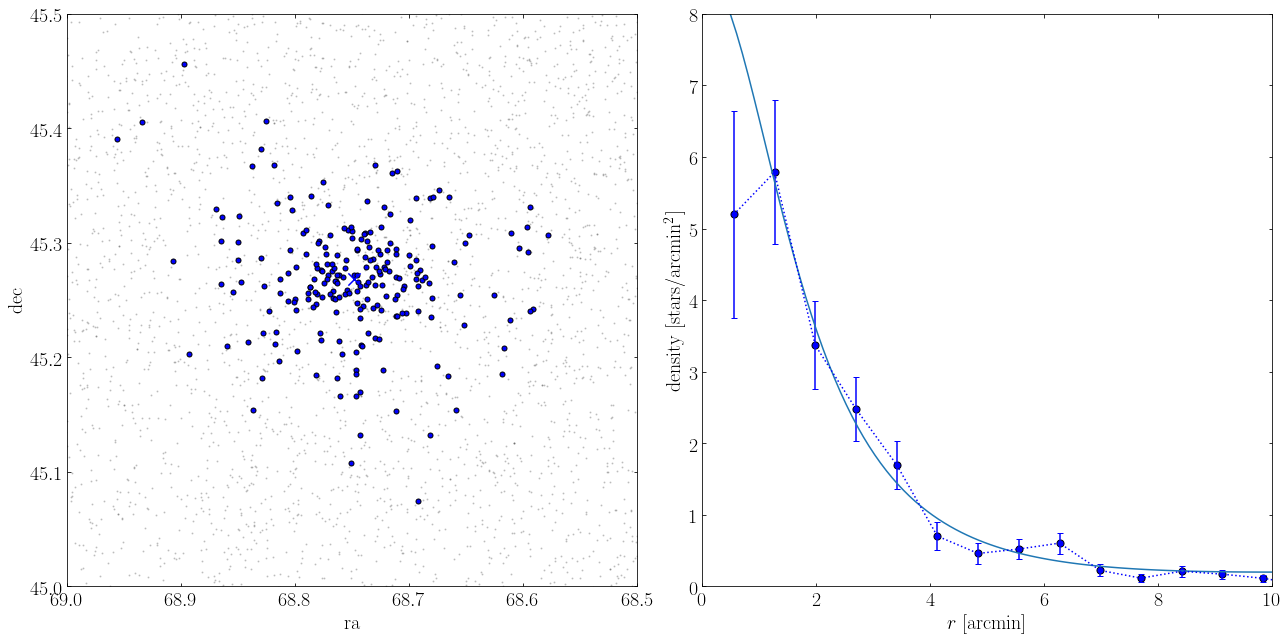

In [11]:
f = plt.figure(figsize=(18, 9), tight_layout=True)
ax = f.add_subplot(121)
plt.scatter(data["ra"], data["dec"], s=1, c="grey", alpha=0.2)
plt.scatter(data["ra"][labels==0], data["dec"][labels==0], s=25)
plt.scatter(ra_cen, dec_cen, s=150, marker="x")
plt.axis([69.0, 68.5, 45.0, 45.5])
ax.set_xlabel("ra")
ax.set_ylabel("dec")

ax = f.add_subplot(122)
# Plot radial density of the HDBSCAN members
plt.errorbar(r_points, r_density, yerr=r_density_err, ls=":", c="b")
plt.scatter(r_points, r_density, s=50)
# King profile (same as above)
plt.plot(x, floor + rho_cen * (1./np.sqrt(1. + (x/r_c)**2.) - (1. / np.sqrt( 1. + (r_t/r_c)**2.) ))**2. )
plt.axis([0,10,0,8])
ax.set_xlabel(r"$r$ [arcmin]")
ax.set_ylabel(r"density [stars/arcmin$^2$]")
plt.savefig("./im/ngc1605_densityprofile.png", dpi=200)
plt.show()

## Parallax analysis

Now let's determine the (zero-point corrected) parallax of NGC 1605 and the new OC candidate. First determine the parallax zeropoint for all stars in the field (following [Lindegren et al. 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...649A...4L/abstract) & shamelessly copying code from the [tutorial of Pau Ramos](https://gitlab.com/icc-ub/public/gaiadr3_zeropoint/-/tree/master/)):

In [12]:
import zpt
zpt.load_tables()
zpvals = zpt.get_zpt(data['phot_g_mean_mag'], data['nu_eff_used_in_astrometry'], 
                     data['pseudocolour'], data['ecl_lat'], data['astrometric_params_solved'])

/home/friedel/Desktop/ngc1605/zpt.py:236: UserWarning: The pseudocolour of some of the 6p source(s) is outside the expected range (1.24-1.72 mag).
                 The maximum corrections are reached already at 1.24 and 1.72
  UserWarning)


Now correct for it and determine the corrected mean parallax (and its uncertainty) for the two found clusters:

In [13]:
parallax_corr = data["parallax"] - zpvals
pi_ngc_1605   = np.mean(parallax_corr[labels==0])
e_pi_ngc_1605 = np.std(parallax_corr[labels==0]) / np.sqrt(np.sum(labels==0))
pi_ngc_new    = np.mean(parallax_corr[labels==1])
e_pi_ngc_new  = np.std(parallax_corr[labels==1]) / np.sqrt(np.sum(labels==1))

print("NGC 1605 corrected parallax:", np.round(pi_ngc_1605,3), r"+-", np.round(e_pi_ngc_1605,3))
print("Candidate OC corrected parallax:", np.round(pi_ngc_new,3), r"+-", np.round(e_pi_ngc_new,3))

NGC 1605 corrected parallax: 0.361 +- 0.006
Candidate OC corrected parallax: 0.332 +- 0.009


## Astrophysical parameters

We check out the astrophysical parameters from StarHorse2021 for the cluster members.

First we need to define some functions that allow us to connect to the AIP Gaia archive:

In [99]:
import gaia_aip_utils

In [96]:
idlist = np.int64(data["source_id"][labels==0])
splits = gaia_aip_utils.get_id2split_multiple_ids(idlist)

In [112]:
import importlib
importlib.reload(gaia_aip_utils)

<module 'gaia_aip_utils' from '/home/friedel/Desktop/ngc1605/gaia_aip_utils.py'>

In [113]:
def pdf_plot_combined_ids(splits):
    for ii in np.arange(len(splits)):
        # Download the correct file
        h5f = gaia_aip_utils.get_splitfile(str(splits.split[2])[2:-1])
        iikeys = np.int64(list(h5f.keys()))
        jj = [i for i,x in enumerate(iikeys) if x == splits.source_id[ii]][0]
        jjd = list(f.keys())[jj]
        example  = f[jjd]
        # extract GMM from HDF5 file
        ndim, nsamples = 5, 10000
        np.random.seed(42)
        data1 = np.random.multivariate_normal(np.array(example['Gauss1_means']), np.array(example['Gauss1_covs']), size=int(example["weights"][0]*nsamples))
        data2 = np.random.multivariate_normal(np.array(example['Gauss2_means']), np.array(example['Gauss2_covs']), size=int(example["weights"][1]*nsamples))
        data3 = np.random.multivariate_normal(np.array(example['Gauss3_means']), np.array(example['Gauss3_covs']), size=int(example["weights"][2]*nsamples))
        samples = np.vstack([data1, data2, data3])
    # corner plot
    plt.figure(figsize=(8,8))
    figure = corner.corner(samples, plot_datapoints=False, show_titles=True, smooth=True,
                           labels=[r"$M_{\rm act}\ [M_{\odot}]$", r"Age [Gyr]", r"[Z/H]", "$d$ [kpc]", r"$A_V$ [mag]"],
                           range=[0.995, 0.995, 0.995, 0.995, 0.995], use_math_text=True, 
                           label_kwargs={"fontsize":25}, title_kwargs={"fontsize":22})
    # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))
    figure.subplots_adjust(right=1.5,top=1.5)
    for ax in figure.get_axes():
        ax.tick_params(axis='both', labelsize=16)
    ax = axes[1, 1]
    #plt.text(3., 1.5, r'source_id '+ str(iid), horizontalalignment='center',
    #         verticalalignment='center', transform = ax.transAxes)
    plt.savefig("im/corner-" + iid +"png", dpi=100, bbox_inches="tight")

In [114]:
pdf_plot_combined_ids(splits)

IndexError: list index out of range

/home/friedel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  if __name__ == '__main__':
/home/friedel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.
/home/friedel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 576x576 with 0 Axes>

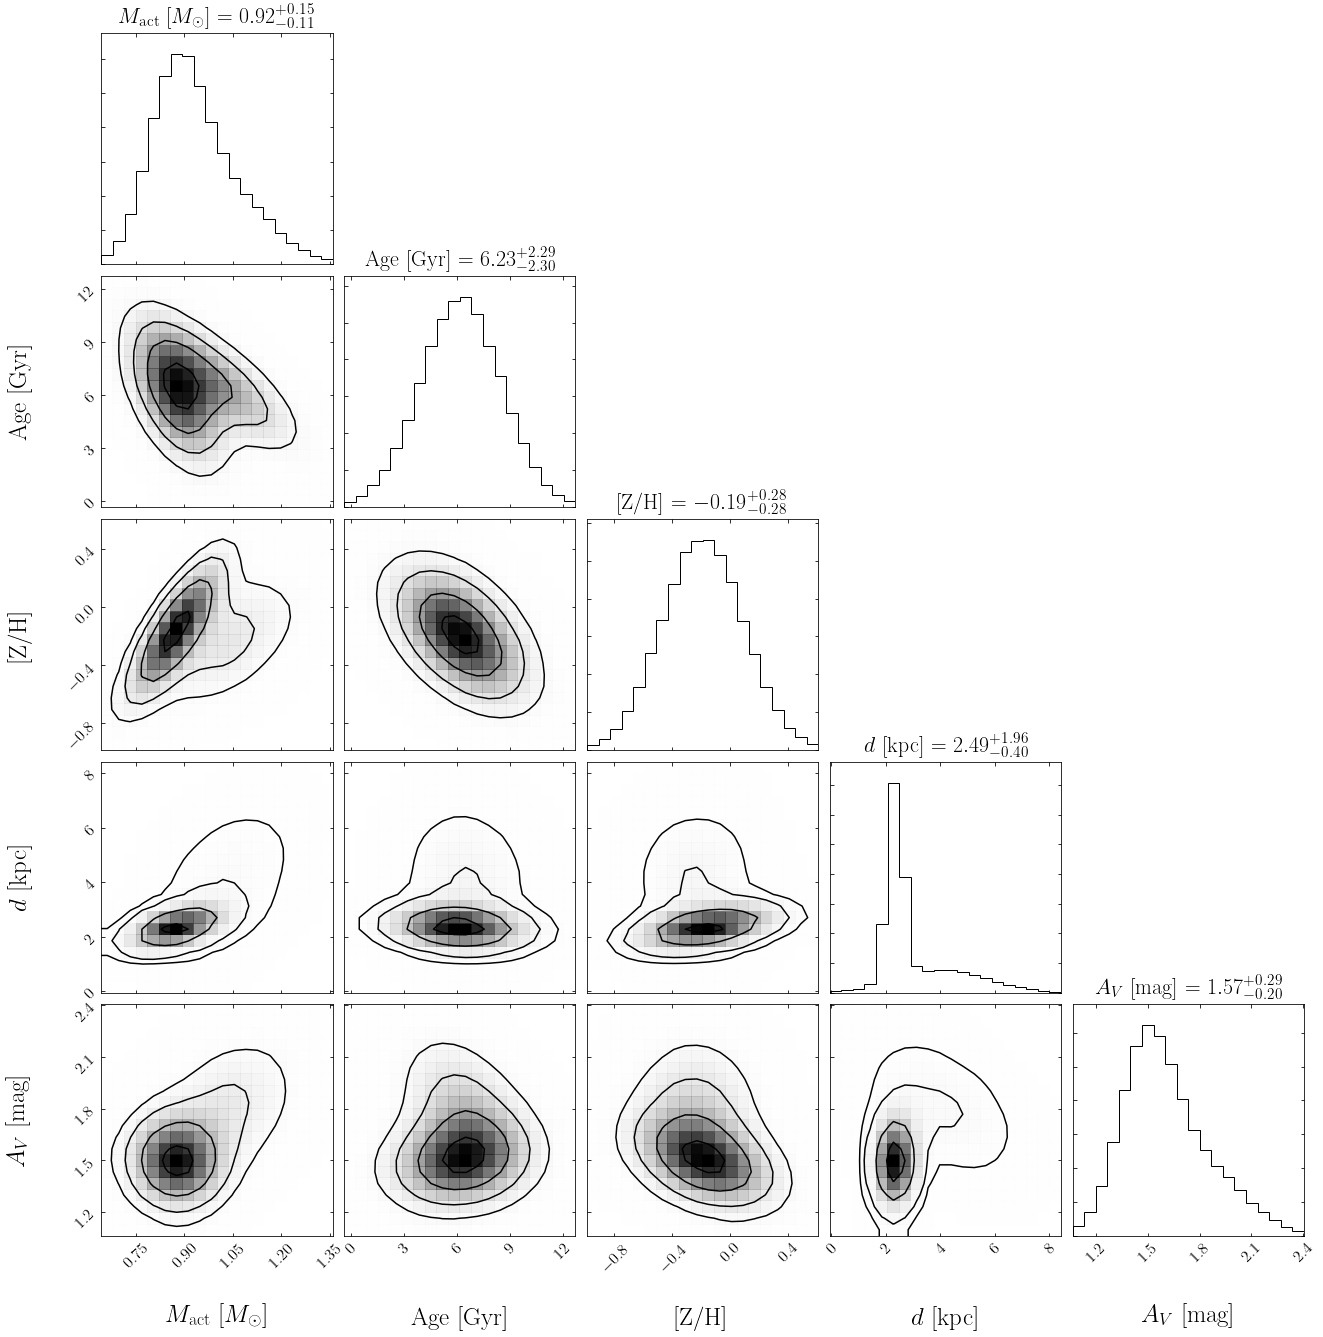

In [92]:
pdf_plot_by_id(h5f, source_id)

### Save the 2 membership lists (if needed)

## Bonus: Hyperparameter tests and other clustering algorithms (for those who want to play)

If we want to play with other clustering algorithms (especially the ones included in scikit-learn), we can define this little function:

In [14]:
from time import time
def plot_clusters_5d(data, algorithm, args, kwds, savefig=None):
    """
    Produces 4x4 2D plots for the chosen HealPix cell
    """
    # costum axis ranges
    axranges = [[], [], [-5,5], [-8,2], [-.5,1]]
    # Run clustering
    start_time = time()
    labels     = algorithm(*args, **kwds).fit_predict(data)
    labels = np.array( labels )
    howmany = np.unique(labels)
    print("Labels:", howmany)
    # Start plotting
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    mask = (labels >= 0)
    colors = np.array([palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels])
    axlabels = ["ra", "dec", r"$\mu_{\rm ra}$", r"$\mu_{\rm dec}$", r"$\varpi$"]
    f = plt.figure( figsize=(12,12))
    plt.suptitle('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    gs = gridspec.GridSpec(4,4)
    gs.update(left=0.1, right=.95, top=.95, bottom=.1, wspace=.05, hspace=.05)
    for ii in howmany:
        if ii < 0:
            pass
        else:
            print("Cluster", ii, ":", np.sum(labels==howmany[ii]), "stars")
    end_time   = time()
    for ii in range(4):
        for jj in range(4):
            if ii>=jj:
                ax = plt.Subplot(f, gs[ii,jj])
                f.add_subplot(ax)
                plt.scatter(data.T[jj], data.T[ii+1], c=colors, s=1, alpha=0.1)
                if np.sum(mask)>0:
                    plt.scatter(data.T[jj][mask], data.T[ii+1][mask], c=colors[mask], alpha=1,
                                lw=0, s=10)
                frame = plt.gca()
                # Beautify axes:
                if ii == 3:
                    ax.set_xlabel(axlabels[jj], fontsize=15)
                else:
                    frame.axes.get_xaxis().set_visible(False)
                if jj == 0:
                    ax.set_ylabel(axlabels[ii+1], fontsize=15)
                else:
                    frame.axes.get_yaxis().set_visible(False)
                if jj>1:
                    plt.xlim(axranges[jj])
                if ii>0:
                    plt.ylim(axranges[ii+1])
    print('Clustering took {:.2f} s'.format(end_time - start_time))
    if savefig!=None:
        plt.savefig(savefig, dpi=200)
    plt.show()


And then, for example, modify our HDBSCAN analysis. Now we look at the **normalised** 5D parameter space and use a smaller min_cluster_size:

Labels: [-1  0  1  2]
Cluster 0 : 10779 stars
Cluster 1 : 17 stars
Cluster 2 : 209 stars
Clustering took 0.60 s


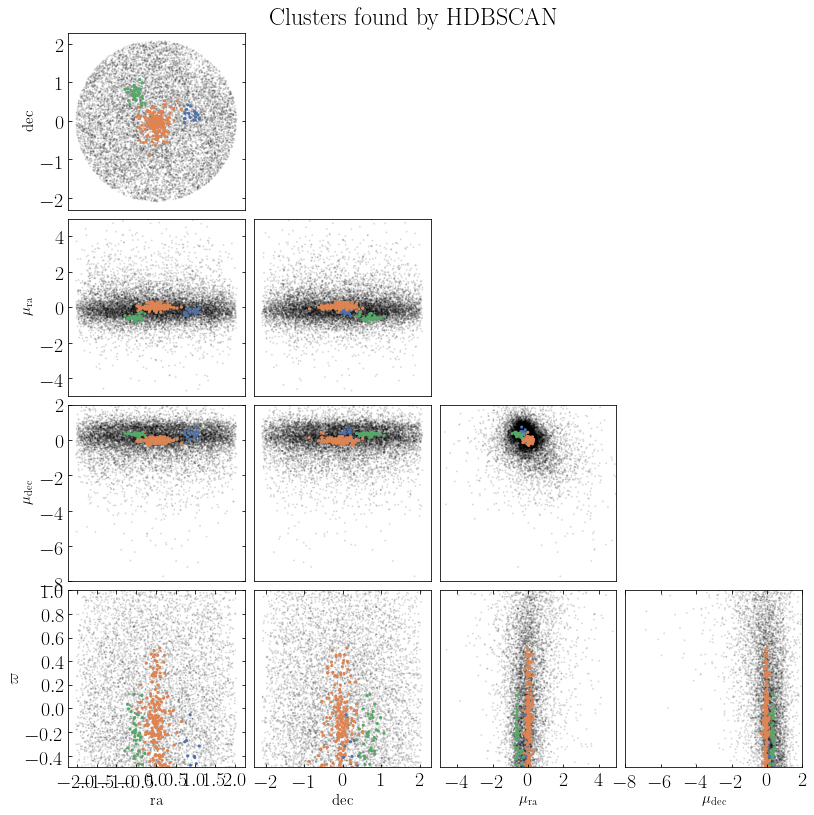

In [15]:
plot_clusters_5d(X, hdbscan.HDBSCAN, (), {'min_cluster_size':17, 'cluster_selection_epsilon':0.01})

Now we have found another overdensity - with negative parallax, however... and not at all robust to parameter changes.